In [3]:
include("Julia_Implementation.jl")
using Random
import Pkg #Pkg is the package manager in Julia
using Distributions
using Plots
using LinearAlgebra
using ProgressMeter
Pkg.update()


LoadError: LoadError: ArgumentError: Package StatsFuns not found in current path.
- Run `import Pkg; Pkg.add("StatsFuns")` to install the StatsFuns package.
in expression starting at e:\Cambridge\Year 4\Fourth Year Projcet\IIB_Codes\Julia_Implementation.jl:1

In [2]:
import Pkg; Pkg.add("ProgressMeter")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed ProgressMeter ─ v1.10.0
    Updating `~/.julia/environments/v1.9/Project.toml`
  [92933f4c] + ProgressMeter v1.10.0
    Updating `~/.julia/environments/v1.9/Manifest.toml`
  [92933f4c] ↑ ProgressMeter v1.9.0 ⇒ v1.10.0
Precompiling project...
  ✓ ProgressMeter
  ✓ ConsoleProgressMonitor
  ✓ AbstractMCMC
  ✓ AdvancedPS
  4 dependencies successfully precompiled in 10 seconds. 203 already precompiled.


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


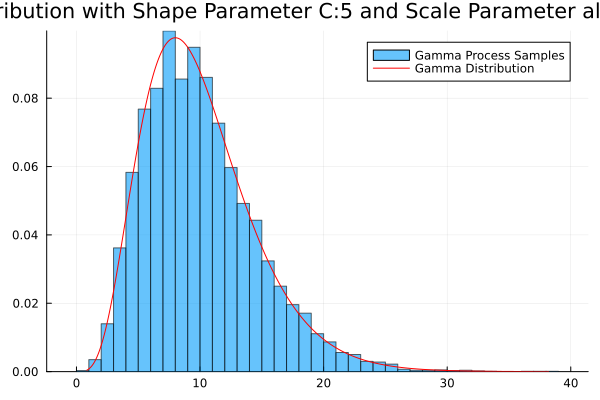

In [4]:
include("Julia_Implementation.jl")
using Random
import Pkg # Pkg is the package manager in Julia
using Distributions
using Plots
using LinearAlgebra
using ProgressMeter
N = 10000 # 样本数量
T = 1 # 模拟时间
beta = 0.5 # 逆比例参数
alpha = 1 / beta # 生成时的比例参数
C = 5 # 速率/形状参数
samples = Float64[]

@showprogress for i in 1:N
    samples_matrix, jump_time_matrix = Julia_Implementation.vectorized_particle_Gamma_generator(beta, C, T, 1, 1, 100)
    gamma_jumps = samples_matrix[1, :]
    gamma_jump_times = jump_time_matrix[1, :]
    sample = Julia_Implementation.integrate([1.0], gamma_jumps, gamma_jump_times)
    push!(samples, sample[1])
end

# 定义x的范围，以匹配samples的范围或更广
x = range(minimum(samples), stop=maximum(samples), length=1000)

p = histogram(samples, bins=50, normalize=true, alpha=0.6, label="Gamma Process Samples")
plot!(p, x, pdf.(Gamma(C, alpha), x), color=:red, label="Gamma Distribution")
title!(p, "Gamma Distribution with Shape Parameter C:$(C) and Scale Parameter alpha (1/beta):$(alpha)")
#legend!(:topright) # 如果需要图例，取消这行注释
display(p)


In [8]:
samples_matrix, jump_time_matrix = Julia_Implementation.vectorized_particle_Gamma_generator(beta, C, T, 1, 1, 100)
print(size(jump_time_matrix))

(1, 100)

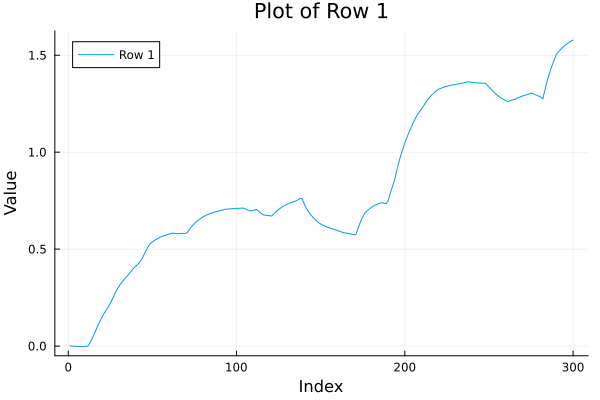

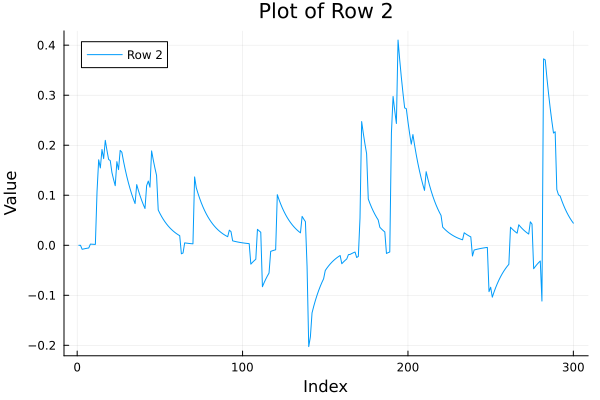

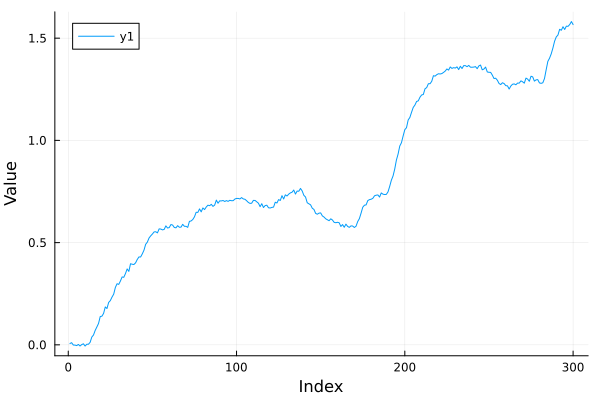

In [1]:
include("Julia_Implementation.jl")
using Random
import Pkg # Pkg is the package manager in Julia
using Distributions
using Plots
using LinearAlgebra
using ProgressMeter

# 参数初始化
beta_pcn = 1.0 # 预条件Crank-Nicolson算法的步长参数
n_iter = 300 # 迭代次数
theta0 = -1.0 # theta的初始猜测
beta0 = 5.0 # beta的初始猜测
C0 = 2.0 # C的初始猜测
num_particles = 1000

# 三个参数的步长
l_theta = 1.0
l_beta = 0.1
l_C = 2.0

# 真实参数值
true_theta = -1.0
kw = 1.0
kv = 0.001
true_sigmaw = 0.2
true_muw = 0.2
sigma_n = true_sigmaw * sqrt(kv)

# 模拟参数
true_beta = 5.0
true_C = 2.0
T = 30.0
N = 10 * round(Int,T) # 分辨率

# 定义Langevin动力学
A = zeros(2, 2)
A[1, 2] = 1.0
A[2, 2] = true_theta
h = [0.0, 1.0]
# 模拟
evaluation_points = range(0, T, length=N)
#print("Hi")
subordinator_jumps, jump_times = Julia_Implementation.vectorized_particle_Gamma_generator(true_beta, true_C, T, 1, 1, 100)# subordinator jump sizes and times
samples = Julia_Implementation.generate_SDE_samples(subordinator_jumps,jump_times,true_muw,true_sigmaw,A,h,evaluation_points)
#print(size(samples))
# 分开绘制每一行
for i in 1:size(samples, 1)
    plot(samples[i, :], label=string("Row ", i))
    title!("Plot of Row $i")
    xlabel!("Index")
    ylabel!("Value")
    display(plot!()) # 使用 display 来显示图表
end

# 生成噪声观测数据
Noisy_samples = samples[1, :] .+ randn(length(samples[1, :])) .* sigma_n

#print(size(Noisy_samples))
# 下一步是基于这些数据进行参数估计或其他分析，这部分代码取决于具体的分析目标
plot(Noisy_samples)
xlabel!("Index")
ylabel!("Value")
display(plot!())





In [1]:
include("Julia_Implementation.jl")
using Random
import Pkg # Pkg is the package manager in Julia
using Distributions
using Plots
using LinearAlgebra
using ProgressMeter

# 参数初始化
beta_pcn = 1.0 # 预条件Crank-Nicolson算法的步长参数
n_iter = 300 # 迭代次数
theta0 = -1.0 # theta的初始猜测
beta0 = 5.0 # beta的初始猜测
C0 = 2.0 # C的初始猜测
num_particles = 1000

# 三个参数的步长
l_theta = 1.0
l_beta = 0.1
l_C = 2.0

# 真实参数值
true_theta = -1.0
kw = 1.0
kv = 0.001
true_sigmaw = 0.2
true_muw = 0.2
sigma_n = true_sigmaw * sqrt(kv)

# 模拟参数
true_beta = 5.0
true_C = 2.0
T = 30.0
N = 10 * round(Int,T) # 分辨率

# 定义Langevin动力学
A = zeros(2, 2)
A[1, 2] = 1.0
A[2, 2] = true_theta
h = [0.0, 1.0]
# 模拟
evaluation_points = range(0, T, length=N)

# 粒子滤波器初始化
trajectory = []

nx0 = 2
X0 = zeros(nx0 + 1, 1)
nx0_new = 3

C_prior = zeros(nx0_new, nx0_new)
C_prior[end, end] = kw

g = [1 0 0]'
R = [kv]

initial_particles = [(zeros(nx0, 1), Matrix{Float64}(I, nx0, nx0)) for _ in 1:num_particles]
previous_Xs = [copy(X0) for _ in 1:num_particles]
previous_X_uncertainties = [copy(C_prior) for _ in 1:num_particles]

initial_weights = ones(num_particles) ./ num_particles

dt = evaluation_points[2] - evaluation_points[1]
matrix_exp = exp(A * dt)
sigma = sigma_n

inferred_Xs = []
inferred_covs = []

particles = initial_particles
histories = [particles]
weights = initial_weights

sigmaw2_values = []
sigmaw2_uncertainties = []
alphas = []
betas = []

mean_proposals, cov_proposals = Julia_Implementation.vectorized_particle_transition_function(true_beta, true_C, T, N, num_particles, A, h, 10)



DimensionMismatch: DimensionMismatch: arrays could not be broadcast to a common size; got a dimension with lengths 1000 and 2

In [13]:
@showprogress for i in 1:length(evaluation_points)
    mean_proposal = mean_proposals[:, i, :, :]
    cov_proposal = cov_proposals[:, i, :, :]
    sigmaw2, sigmaw2_uncertainty = Julia_Implementation.inverted_gamma_to_mean_variance(alphaws, betaws, weights)
    sigmaw = sqrt.(sigmaw2)

    push!(sigmaw2_values, sigmaw2)
    push!(sigmaw2_uncertainties, sigmaw2_uncertainty)

    t = evaluation_points[i]
    observation = Noisy_samples[i]
    previous_Xs, previous_X_uncertainties, _, _, weights, alphaws, betaws, accumulated_Es, accumulated_Fs = Julia_Implementation.ultimate_NVM_pf(observation, previous_Xs, previous_X_uncertainties, mean_proposal, cov_proposal, matrix_exp, g, R, alphaws, betaws, accumulated_Es, accumulated_Fs, i)
    inferred_cov = weighted_sum(previous_X_uncertainties, weights) .* sigmaw2
    inferred_X = weighted_sum(previous_Xs, weights)

    push!(inferred_Xs, inferred_X)
    push!(inferred_covs, inferred_cov)
end

[0.7066333735417496 12.573434911763467 1.6337959263918045 24.597888328005318 18.380372518799508 3.3614051390003272 2.135182945890588 13.058981247984617 1.7714738888131754 18.01561541758906 18.22318804874981 28.470307490320064 21.762867410057805 25.112197126405214 0.18942983836535698 18.941007714128208 19.982948735479525 26.724447482002955 27.77712845749285 21.874984162635975 17.415590143908307 26.838971001713897 28.911609026975068 21.214033168709147 2.3395040543457943 17.12762997863568 27.060297673140425 13.14288171084608 23.648799632818378 16.809756284612604 3.669769581686549 13.669841018678376 25.320968257015018 25.218755378762495 12.932875647437774 26.739645879562225 24.357975922516708 0.8292035777504425 9.14430526454919 16.9541840420931 6.3621622128492685 27.029259427911658 28.110658930537525 5.5582815189180215 18.569505252831625 17.647895853005764 8.193035702453468 3.8399360794794104 29.982568610566148 25.097151905536464 21.42975385126534 18.027335865182412 10.110676443651462 14.8

In [8]:
include("Julia_Implementation.jl")
using Random
import Pkg # Pkg is the package manager in Julia
using Distributions
using Plots
using LinearAlgebra
using ProgressMeter

# 参数初始化
beta_pcn = 1.0 # 预条件Crank-Nicolson算法的步长参数
n_iter = 300 # 迭代次数
theta0 = -1.0 # theta的初始猜测
beta0 = 5.0 # beta的初始猜测
C0 = 2.0 # C的初始猜测
num_particles = 1000

# 三个参数的步长
l_theta = 1.0
l_beta = 0.1
l_C = 2.0

# 真实参数值
true_theta = -1.0
kw = 1.0
kv = 0.001
true_sigmaw = 0.2
true_muw = 0.2
sigma_n = true_sigmaw * sqrt(kv)

# 模拟参数
true_beta = 5.0
true_C = 2.0
T = 30.0
N = 10 * round(Int,T) # 分辨率

# 定义Langevin动力学
A = zeros(2, 2)
A[1, 2] = 1.0
A[2, 2] = true_theta
h = [0.0, 1.0]
# 模拟
h_expanded = repeat(h, outer=(1, 1, size(A)...))
A_expanded = repeat(A, outer=(1, 1, size(A)...))
product = A_expanded.*h_expanded 

2×2×2×2 Array{Float64, 4}:
[:, :, 1, 1] =
 0.0   0.0
 0.0  -1.0

[:, :, 2, 1] =
 0.0   0.0
 0.0  -1.0

[:, :, 1, 2] =
 0.0   0.0
 0.0  -1.0

[:, :, 2, 2] =
 0.0   0.0
 0.0  -1.0